In [4]:
import networkx

In [5]:
import requests

In [6]:
paicquicProviderURL="http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search"
miqlMethod="query"
miqlField="pubid"
miqlValue="17446270"

miqlRequest=f"{paicquicProviderURL}/{miqlMethod}/{miqlField}:{miqlValue}"

print (miqlRequest)
    
try:
    httpReq = requests.get(miqlRequest, proxies=None)
except NameError:
    httpReq = requests.get(miqlRequest)
ans = httpReq.text
print(ans)

http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search/query/pubid:17446270
uniprotkb:P0CW72	uniprotkb:P0CW72	intact:EBI-2620133|uniprotkb:Q777A5	intact:EBI-2620133|uniprotkb:Q777A5	psi-mi:barf1_ebvg(display_long)|uniprotkb:BARF1(gene name)|psi-mi:BARF1(display_short)|uniprotkb:33 kDa early protein(gene name synonym)|uniprotkb:p33(gene name synonym)	psi-mi:barf1_ebvg(display_long)|uniprotkb:BARF1(gene name)|psi-mi:BARF1(display_short)|uniprotkb:33 kDa early protein(gene name synonym)|uniprotkb:p33(gene name synonym)	psi-mi:"MI:0397"(two hybrid array)	Calderwood et al. (2007)	imex:IM-20435|mint:MINT-6769080|pubmed:17446270	taxid:10376(ebvg)|taxid:10376("Epstein-Barr virus (strain B95-8)")	taxid:10376(ebvg)|taxid:10376("Epstein-Barr virus (strain B95-8)")	psi-mi:"MI:0915"(physical association)	psi-mi:"MI:0469"(IntAct)	intact:EBI-2620961|imex:IM-20435-3	author score:+|intact-miscore:0.51
uniprotkb:P0C704	uniprotkb:P14348	intact:EBI-2620975|uniprotkb:Q3KSQ5	intac

In [7]:
import re

def mitabReader(httpText):
    for line in ans.split("\n"): #on prend le fichier lignes par lignes
        _ = line.split("\t") #on split en fonction des tabulations
        if len(_) > 1 and _[0].startswith("uniprotkb:")\
                      and _[1].startswith("uniprotkb:"): #si on a bien les identifiants des deux protÃ©ines
            yield [ _[0].replace("uniprotkb:", ""),\
                    _[1].replace("uniprotkb:", "") ]\
                  + _[2:] #on remplace les nom des champs par un espace
                
            
def isMitab_EBV_EBV(mitabArray):
    reEBV   = "taxid:(1037[6-7]|82830)"
    if re.search(reEBV, mitabArray[9]) and re.search(reEBV, mitabArray[10]):
        return True
    return False

def isMitab_Human_EBV(mitabLine):
    reHuman = "taxid:(9606)"
    reEBV   = "taxid:(1037[6-7]|82830)"
    if (re.search(reEBV, mitabArray[9]) and re.search(reHuman, mitabArray[10]))\
    or (re.search(reHuman, mitabArray[9]) and re.search(reEBV, mitabArray[10])):
        return True
    return False


EBV_EBV_mitab   = []
EBV_Human_mitab = []
total = 0
for mitabArray in mitabReader(ans):
    total += 1
    if isMitab_EBV_EBV(mitabArray):
        EBV_EBV_mitab.append(mitabArray)
    elif isMitab_Human_EBV(mitabArray):
        EBV_Human_mitab.append(mitabArray)
    else : 
        raise ValueError("Je ne connais pas cette espece ==> ", mitabArray[9:11])

print(len(EBV_EBV_mitab))
print(len(EBV_Human_mitab))
print(EBV_EBV_mitab)
print(f"Nombre total d'interactions {total}, EBV-EBV {len(EBV_EBV_mitab)}")



59
171
[['P0CW72', 'P0CW72', 'intact:EBI-2620133|uniprotkb:Q777A5', 'intact:EBI-2620133|uniprotkb:Q777A5', 'psi-mi:barf1_ebvg(display_long)|uniprotkb:BARF1(gene name)|psi-mi:BARF1(display_short)|uniprotkb:33 kDa early protein(gene name synonym)|uniprotkb:p33(gene name synonym)', 'psi-mi:barf1_ebvg(display_long)|uniprotkb:BARF1(gene name)|psi-mi:BARF1(display_short)|uniprotkb:33 kDa early protein(gene name synonym)|uniprotkb:p33(gene name synonym)', 'psi-mi:"MI:0397"(two hybrid array)', 'Calderwood et al. (2007)', 'imex:IM-20435|mint:MINT-6769080|pubmed:17446270', 'taxid:10376(ebvg)|taxid:10376("Epstein-Barr virus (strain B95-8)")', 'taxid:10376(ebvg)|taxid:10376("Epstein-Barr virus (strain B95-8)")', 'psi-mi:"MI:0915"(physical association)', 'psi-mi:"MI:0469"(IntAct)', 'intact:EBI-2620961|imex:IM-20435-3', 'author score:+|intact-miscore:0.51'], ['P0C704', 'P14348', 'intact:EBI-2620975|uniprotkb:Q3KSQ5', 'intact:EBI-2620158|uniprotkb:Q777G5|intact:EBI-9645437', 'psi-mi:mcp_ebvg(display_

In [14]:
import re
import networkx as nx

G_EBV = nx.Graph()

for paqDatum in EBV_EBV_mitab : 
    G_EBV.add_edge(paqDatum[0],paqDatum[1])
print(G_EBV)

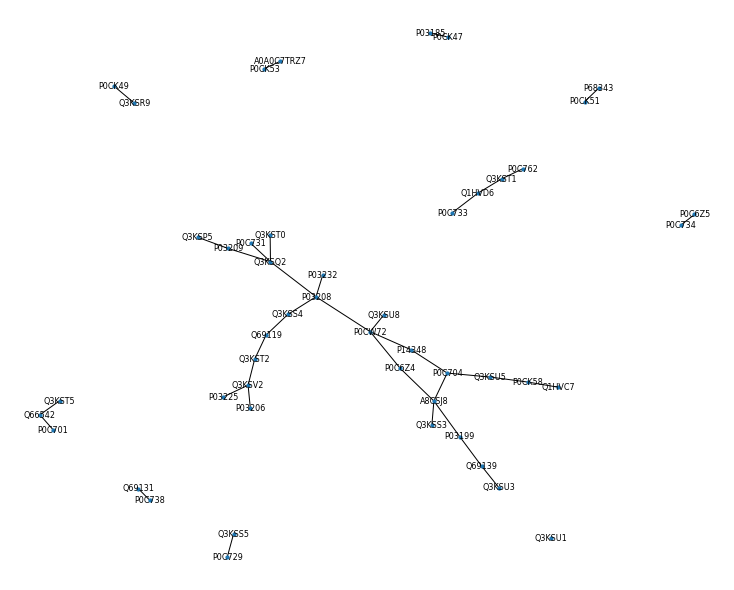

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
nx.draw(G_EBV,with_labels=True,node_size=5, font_size=8,linewidths=2)
plt.show()

In [17]:
from xml.etree.ElementTree import parse, dump, fromstring, register_namespace, ElementTree

# Utility functions
# Extracting All go terms relative to provided UNIPROT accessor
def goTerms(xmlEntry):
    ns = '{http://uniprot.org/uniprot}'
    goTerms = xmlEntry.findall(ns +'dbReference[@type="GO"]')
    goTermList = []
    for goT in goTerms:
        gID   = goT.attrib['id']
        gName = goT.find(ns +'property[@type="term"]').attrib['value']
        goTermList.append({"name" : gName, "ID" : gID})
    return goTermList

# Return information about provided UNIPROT accessor as python dictionary
def proteinDict(uniprotID, root):
    ns   = '{http://uniprot.org/uniprot}'

    data = { "accession" : uniprotID,
             "geneName" : None,
             "name" : None,
             "GOterms" : None
           }

    for entry in root.findall(ns+'entry'):
        accessions = entry.findall(ns+"accession")
        for acc in accessions:
            if acc.text == uniprotID: # entry is the node matching provided UNIPROT accessor
                e = entry.find(f"{ns}protein/{ns}recommendedName/{ns}fullName")
                if not e is None:
                    data["name"] = e.text
                e = entry.find(f"{ns}gene/{ns}name")
                if not e is None:
                    data["geneName"] = e.text

                data["GOterms"] = goTerms(entry)
                return data
    raise ValueError(f"{uniprotID} nor found in XML document")

# Test
tree = parse('./data/Calderwood_Human_proteome.xml')
root = tree.getroot()
proteinDict("Q53Y88", root)

{'accession': 'Q53Y88',
 'geneName': 'GRN',
 'name': 'Progranulin',
 'GOterms': [{'name': 'C:azurophil granule lumen', 'ID': 'GO:0035578'},
  {'name': 'C:endoplasmic reticulum', 'ID': 'GO:0005783'},
  {'name': 'C:endosome', 'ID': 'GO:0005768'},
  {'name': 'C:extracellular exosome', 'ID': 'GO:0070062'},
  {'name': 'C:extracellular region', 'ID': 'GO:0005576'},
  {'name': 'C:extracellular space', 'ID': 'GO:0005615'},
  {'name': 'C:Golgi apparatus', 'ID': 'GO:0005794'},
  {'name': 'C:late endosome', 'ID': 'GO:0005770'},
  {'name': 'C:lysosomal membrane', 'ID': 'GO:0005765'},
  {'name': 'C:lysosome', 'ID': 'GO:0005764'},
  {'name': 'C:membrane', 'ID': 'GO:0016020'},
  {'name': 'C:plasma membrane', 'ID': 'GO:0005886'},
  {'name': 'C:trans-Golgi network', 'ID': 'GO:0005802'},
  {'name': 'F:chaperone binding', 'ID': 'GO:0051087'},
  {'name': 'F:cytokine activity', 'ID': 'GO:0005125'},
  {'name': 'F:growth factor activity', 'ID': 'GO:0008083'},
  {'name': 'F:RNA binding', 'ID': 'GO:0003723'},


In [19]:
tree = parse('./data/Calderwood_EBV_proteome.xml')
root = tree.getroot()

EBV_EBV_geneLabels= {}
for node in G_EBV.nodes():
    pDict=proteinDict(node,root)
    EBV_EBV_geneLabels[node]=pDict["geneName"] if pDict["geneName"]else str(node)
EBV_EBV_geneLabels

{'P0CW72': 'BARF1',
 'P0C704': 'MCP',
 'P14348': 'SCP',
 'P03185': 'NEC2',
 'P0CK47': 'NEC1',
 'P0C731': 'BGLF4',
 'Q3KSQ2': 'TK',
 'P0CK53': 'BGLF2',
 'A0A0C7TRZ7': 'BSLF1',
 'Q3KST5': 'BLRF2',
 'Q66542': 'BNRF1',
 'Q3KSS4': 'EBNA1',
 'P03209': 'BRLF1',
 'Q3KSP5': 'LF2',
 'Q3KSU8': 'BPLF1',
 'Q3KSU1': 'BMLF1',
 'Q3KSV2': 'EBNA2',
 'P03206': 'BZLF1',
 'Q3KST2': 'EBNA3',
 'P03225': 'BDLF2',
 'Q3KSU5': 'RIR1',
 'P0C729': 'LMP2',
 'Q3KSS5': 'BRRF2',
 'Q69119': 'Q69119',
 'Q3KST0': 'EBNA6',
 'P0CK58': 'BALF1',
 'P03208': 'BILF1',
 'Q69131': 'BN-LF2a',
 'P0C738': 'BNLF2a',
 'P0C701': 'RIR2',
 'Q1HVC7': 'BVRF2',
 'P0CK49': 'BSRF1',
 'Q3KSR9': 'BBRF1',
 'P0C734': 'BTRF1',
 'P0C6Z5': 'BZLF2',
 'Q3KSS3': 'gL',
 'A8CSJ8': 'LMP1',
 'P68343': 'BLLF1',
 'P0CK51': 'BBLF1',
 'P03199': 'BLLF2',
 'Q69139': 'Q69139',
 'P0C6Z4': 'gN',
 'Q3KSU3': 'BMRF1',
 'P03232': 'BXRF1',
 'Q3KST1': 'EBNA4',
 'P0C762': 'gB',
 'P0C733': 'BNLF2b',
 'Q1HVD6': 'TRX2'}

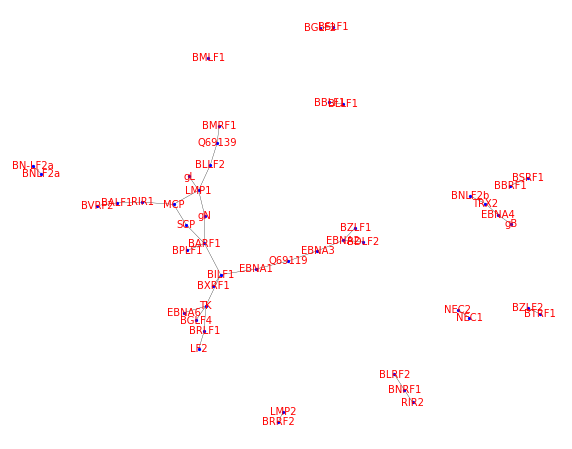

In [20]:
plt.figure(figsize=(10,8))
plt.axis('off')

pos=nx.spring_layout(G_EBV)
nx.draw_networkx_nodes(G_EBV,pos,node_size=5,node_color="blue")
nx.draw_networkx_labels(G_EBV,pos,EBV_EBV_geneLabels,font_size=10,font_weight=400,font_color='r')
nx.draw_networkx_edges(G_EBV,pos,width=0.3)

plt.show()

In [24]:
G2 =nx.Graph()
humanGeneLabels={}
ebvGeneLabels={}
reHuman="taxid:9606"

for paqDatum in EBV_Human_mitab:
    #print(paqDatum)
    (a,b)=(paqDatum[0],paqDatum[1])
    G2.add_edge(a,b)
    (a,b)=(a,b) if re.search(reHuman,paqDatum[9]) else (b,a)
    humanGeneLabels[a]=None
    ebvGeneLabels[b]=None
    
tree=parse('./data/Calderwood_Human_proteome.xml')
root=tree.getroot()
for humanID in humanGeneLabels.keys():
    pDict=proteinDict(humanID,root)
    humanGeneLabels[humanID]=pDict["geneName"] if pDict["geneName"] else humanID
    
tree=parse('./data/Calderwood_EBV_proteome.xml')
root=tree.getroot()
for ebvID in ebvGeneLabels.keys():
    pDict=proteinDict(ebvID,root)
    ebvGeneLabels[ebvID]=pDict["geneName"] if pDict["geneName"] else ebvID


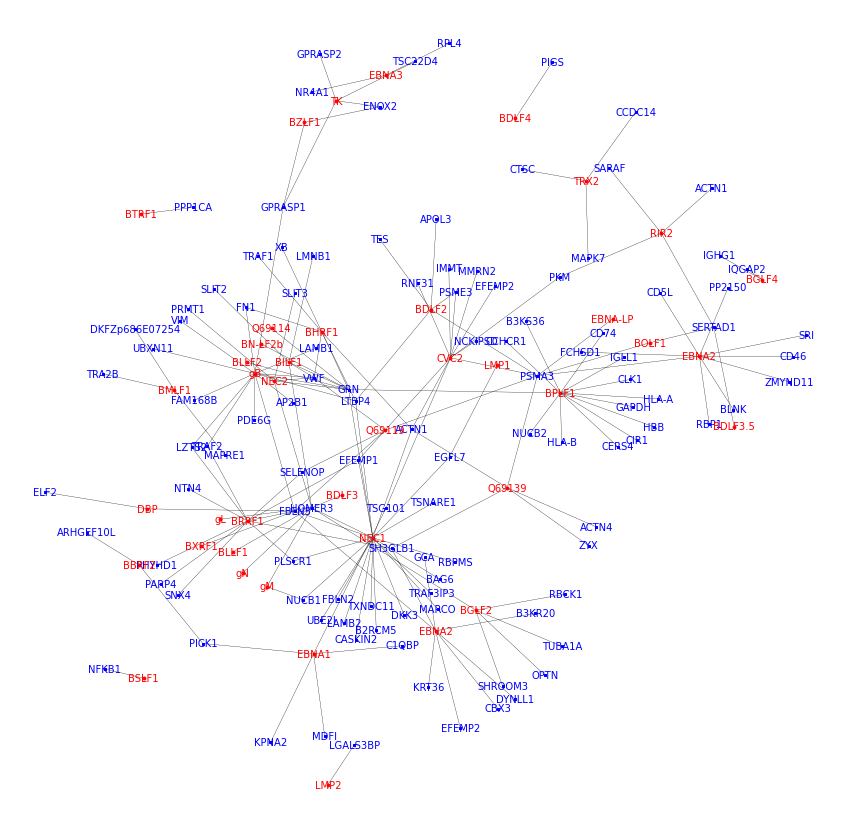

In [28]:
plt.figure(figsize=(15,15))
plt.axis('off')

#pos=nx.draw(G, with_labels=False)
pos=nx.spring_layout(G2, k=0.225)

nx.draw_networkx_nodes(G2,pos,node_size=8,node_color="blue", node_shape="s",nodelist=humanGeneLabels.keys())
nx.draw_networkx_nodes(G2,pos,node_size=8,node_color="red", node_shape="o",nodelist=ebvGeneLabels.keys())
nx.draw_networkx_labels(G2,pos,humanGeneLabels,font_size=10,font_weight=400,font_color='blue')
nx.draw_networkx_labels(G2,pos,ebvGeneLabels,font_size=10,font_weight=400,font_color='red')
nx.draw_networkx_edges(G2,pos,width=0.3)

plt.show()
